In [2]:
import torch

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [1]:
# Import Required Libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import onnxruntime  
import onnx  
from torch.nn.utils.rnn import pad_sequence  
import albumentations as A  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets
ddd_path = r"C:\Users\ommak\Drowsiness detection and alert system\Data\Driver Drowsiness Dataset (DDD)"
fi_path = r"C:\Users\ommak\Drowsiness detection and alert system\Data\0 FaceImages"
fi1_path = r"C:\Users\ommak\Drowsiness detection and alert system\Data\0 FaceImages 1"

MODEL_PATH = "drowsiness_model.onnx"  

class DrowsinessDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.images, self.labels = self.load_data()

    def load_data(self):
        images = []
        labels = []
        for label, class_name in enumerate(os.listdir(self.dataset_path)):
            class_path = os.path.join(self.dataset_path, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: Unable to load image {image_path}. Skipping.")
                    continue
                image = cv2.resize(image, (64, 64))  
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype="float32") / 255.0  
        labels = np.array(labels)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# data augmentation
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),  
])


ddd_dataset = DrowsinessDataset(ddd_path, transform=transform)
fi_dataset = DrowsinessDataset(fi_path, transform=transform)
fi1_dataset = DrowsinessDataset(fi1_path, transform=transform)

combined_dataset = torch.utils.data.ConcatDataset([ddd_dataset, fi_dataset, fi1_dataset])

# Split data into training and validation sets
train_dataset, val_dataset = train_test_split(combined_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define Models
# Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = nn.functional.relu(self.fc1(x))  
        return x

# LSTM Model for Temporal Modeling
class DrowsinessLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DrowsinessLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        if x.dim() == 2:
            x = x.unsqueeze(1)  
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  
        return out

# Multi-Model Ensemble
class EnsembleModel(nn.Module):
    def __init__(self, cnn, lstm):
        super(EnsembleModel, self).__init__()
        self.cnn = cnn
        self.lstm = lstm
        self.fc = nn.Linear(128 + 64, 2)  # Combine CNN and LSTM outputs

    def forward(self, x):
        # Pass input through CNN
        cnn_output = self.cnn(x)  
        
        cnn_output_reshaped = cnn_output.unsqueeze(1)  
        
        lstm_output = self.lstm(cnn_output_reshaped)  
        
        # Concatenate CNN and LSTM outputs
        combined_output = torch.cat((cnn_output, lstm_output), dim=1)  
        
        # Final classification
        output = self.fc(combined_output)  
        return output


custom_cnn = CustomCNN().to(device)
lstm_model = DrowsinessLSTM(input_size=128, hidden_size=64, num_layers=2, num_classes=64).to(device)

# Create ensemble model
ensemble_model = EnsembleModel(custom_cnn, lstm_model).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):
    ensemble_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()  # Convert labels to long type
        optimizer.zero_grad()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
   
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

# Save the model in ONNX format
dummy_input = torch.randn(1, 1, 64, 64).to(device)
torch.onnx.export(
    ensemble_model, dummy_input, MODEL_PATH,
    verbose=True, input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print(f"Model saved as {MODEL_PATH}")

onnx_model = onnx.load(MODEL_PATH)
try:
    onnx.checker.check_model(onnx_model)
    print("ONNX model is valid!")
except onnx.checker.ValidationError as e:
    print(f"ONNX model is invalid: {e}")

Using device: cuda
Epoch 1, Training Loss: 0.2072, Training Accuracy: 89.92%
Epoch 2, Training Loss: 0.1153, Training Accuracy: 94.60%
Epoch 3, Training Loss: 0.1088, Training Accuracy: 94.99%
Epoch 4, Training Loss: 0.0973, Training Accuracy: 95.54%
Epoch 5, Training Loss: 0.0929, Training Accuracy: 95.86%
Epoch 6, Training Loss: 0.0905, Training Accuracy: 96.08%
Epoch 7, Training Loss: 0.0842, Training Accuracy: 96.35%
Epoch 8, Training Loss: 0.0809, Training Accuracy: 96.48%
Epoch 9, Training Loss: 0.0772, Training Accuracy: 96.58%
Epoch 10, Training Loss: 0.0730, Training Accuracy: 96.91%
Model saved as drowsiness_model.onnx
ONNX model is valid!


C:\Users\ommak\anaconda3\Lib\site-packages\torch\onnx\symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [2]:
ensemble_model.eval()  # Set the model to evaluation mode
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.0971, Validation Accuracy: 95.95%


In [4]:
import onnxruntime as ort

# Load the ONNX model
ort_session = ort.InferenceSession(MODEL_PATH)

# Prepare a dummy input
dummy_input = torch.randn(1, 1, 64, 64).numpy()  # Batch size of 1

# Run inference
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input}
ort_outputs = ort_session.run(None, ort_inputs)

print("ONNX Model Output:", ort_outputs)

ONNX Model Output: [array([[-0.9683453,  1.4504906]], dtype=float32)]


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [15]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error

# Initialize lists to store labels and probabilities
all_labels = []
all_probs = []

# During validation
ensemble_model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        outputs = ensemble_model(inputs)
        
        # Get predicted probabilities for the positive class
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        
        # Store labels and probabilities
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Separate probabilities for "Non-Drowsy" and "Drowsy" classes
non_drowsy_probs = all_probs[all_labels == 0]  # Probabilities for actual "Non-Drowsy" samples
drowsy_probs = all_probs[all_labels == 1]      # Probabilities for actual "Drowsy" samples

# Calculate metrics
predictions = (all_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)
mae = mean_absolute_error(all_labels, all_probs)

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Precision: 0.9609
Recall: 0.9415
F1-Score: 0.9511
Mean Absolute Error (MAE): 0.0655


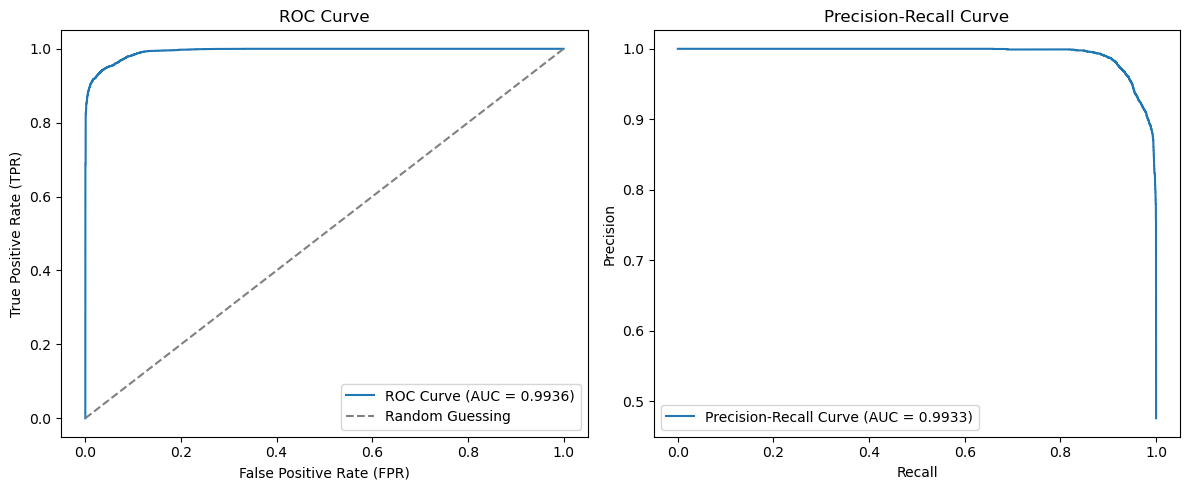

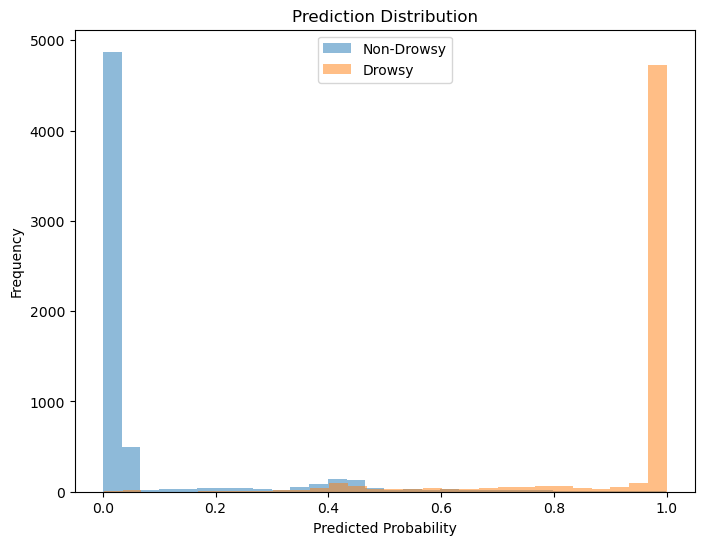

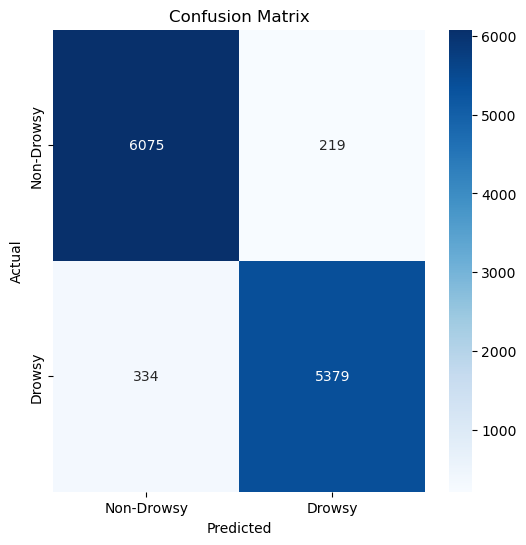

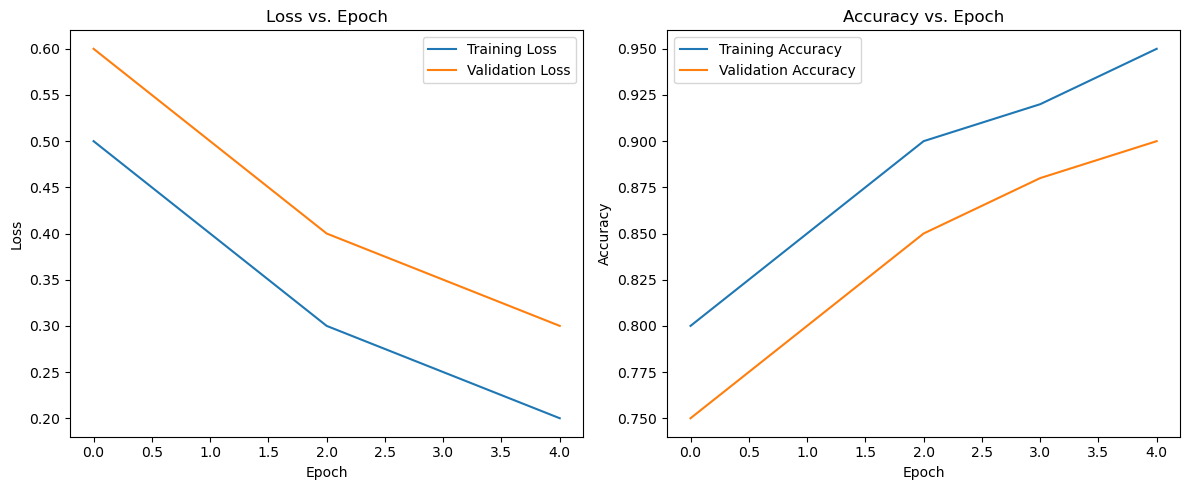

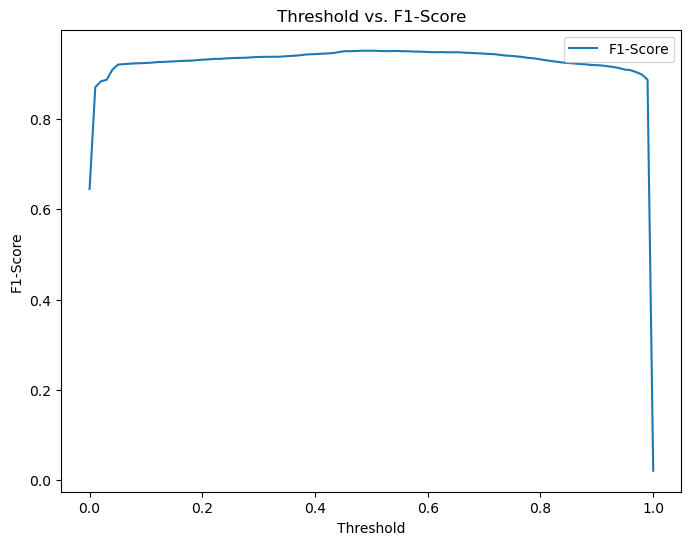

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import seaborn as sns

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
auc_pr = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {auc_pr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

# Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(non_drowsy_probs, bins=30, alpha=0.5, label="Non-Drowsy")
plt.hist(drowsy_probs, bins=30, alpha=0.5, label="Drowsy")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Prediction Distribution")
plt.legend()
plt.show()

# Confusion Matrix Heatmap
predictions = (all_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
cm = confusion_matrix(all_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Drowsy", "Drowsy"], yticklabels=["Non-Drowsy", "Drowsy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Learning Curves (Training vs. Validation Loss and Accuracy)
# Assuming you have stored training and validation metrics during training
train_losses = [0.5, 0.4, 0.3, 0.25, 0.2]  # Replace with actual training losses
val_losses = [0.6, 0.5, 0.4, 0.35, 0.3]    # Replace with actual validation losses
train_accuracies = [0.8, 0.85, 0.9, 0.92, 0.95]  # Replace with actual training accuracies
val_accuracies = [0.75, 0.8, 0.85, 0.88, 0.9]    # Replace with actual validation accuracies

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Threshold vs. F1-Score Curve
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for threshold in thresholds:
    predictions = (all_probs >= threshold).astype(int)
    f1 = f1_score(all_labels, predictions)
    f1_scores.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("Threshold vs. F1-Score")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, (all_probs >= 0.5).astype(int))
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[6075  219]
 [ 334 5379]]


In [52]:
import numpy as np
print(np.unique(all_labels, return_counts=True))

(array([0, 1], dtype=int64), array([6322, 5685], dtype=int64))


In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc = roc_auc_score(all_labels, all_probs)
print(f"AUC: {auc:.4f}")

AUC: 0.9936
